In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.io import read_image
from tqdm import tqdm
import torchvision
import torch.nn as nn
from skimage import exposure
from skimage.exposure import match_histograms
torch.cuda.empty_cache()
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
import wandb

In [ ]:
import torch

# Example logits from a neural network for a single sample (6 classes)
logits = torch.tensor([2.0, 1.0, 0.1, 3.0, 1.5, 2.5])

# Apply softmax
probabilities = torch.softmax(logits, dim=0)

# Print the probabilities
print(probabilities)
print("Sum of probabilities:", probabilities.sum().item())


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="cxr_preprocessing",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "DenseNet",
    "dataset": "CheXpert",
    "epochs": 20,
    }
)

In [2]:
training_file_path =  r'..\..\datasets\CheXpert-v1.0-small\train.csv'
training_data = pd.read_csv(training_file_path)

In [ ]:
training_data.head()

In [ ]:
training_data.isnull().sum()

In [ ]:
sample_image = r'..//..//datasets' + '/' + str(training_data['Path'][0])
img = plt.imread(sample_image)
equalized_image = exposure.equalize_hist(img)
ref_img = plt.imread('../../datasets/reference_img.jpg')
img = np.array(img, dtype=np.float16)
ref_img = np.array(ref_img, dtype=np.float16)
matched_img = exposure.match_histograms(img, ref_img)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(12, 10))

# Show images
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(equalized_image, cmap='gray')
ax[0, 1].set_title('Equalized Image')
ax[0, 2].imshow(matched_img, cmap='gray')
ax[0, 2].set_title('Histogram Matched Image')

# Histograms (Intensity Distribution)
ax[1, 0].hist(img.ravel(), bins=256, range=(0, 255))
ax[1, 0].set_title('Original Image Histogram')
ax[1, 1].hist(equalized_image.ravel(), bins=256, range=(0, 1))
ax[1, 1].set_title('Equalized Image Histogram')
ax[1, 2].hist(matched_img.ravel(), bins=256, range=(0, 1))
ax[1, 2].set_title('Matched Image Histogram')

# Cumulative Histograms
ax[2, 0].hist(img.ravel(), bins=256, range=(0, 255), cumulative=True)
ax[2, 0].set_title('Original Cumulative Histogram')
ax[2, 1].hist(equalized_image.ravel(), bins=256, range=(0, 1), cumulative=True)
ax[2, 1].set_title('Equalized Cumulative Histogram')
ax[2, 2].hist(matched_img.ravel(), bins=256, range=(0, 1), cumulative=True)
ax[2, 2].set_title('Matched Cumulative Histogram')

# Improve layout
plt.tight_layout()
plt.show()


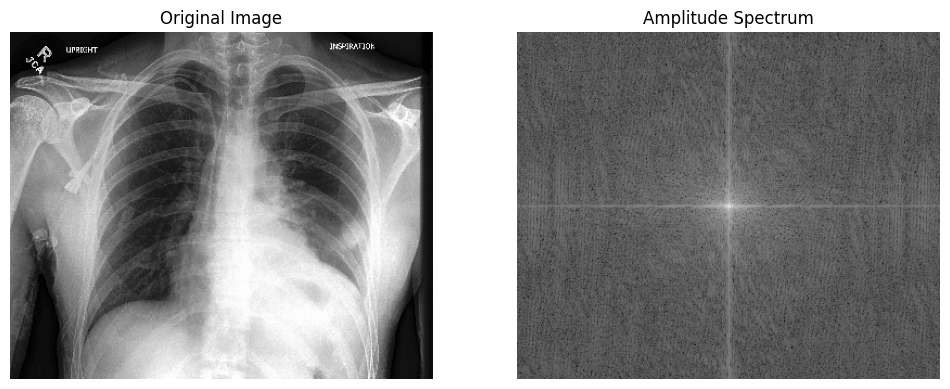

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sample_image = r'..//..//datasets' + '/' + str(training_data['Path'][10])
image = plt.imread(sample_image)
# Compute the 2D Fourier Transform
f_transform = np.fft.fft2(image)

# Shift the zero frequency component to the center
f_shift = np.fft.fftshift(f_transform)

# Compute the amplitude spectrum
amplitude_spectrum = np.abs(f_shift)

# Apply logarithmic scaling for better visualization
log_amplitude_spectrum = np.log(1 + amplitude_spectrum)

# Plot the original image and its amplitude spectrum
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Amplitude Spectrum
plt.subplot(1, 2, 2)
plt.imshow(log_amplitude_spectrum, cmap="gray")
plt.title("Amplitude Spectrum")
plt.axis("off")

plt.show()


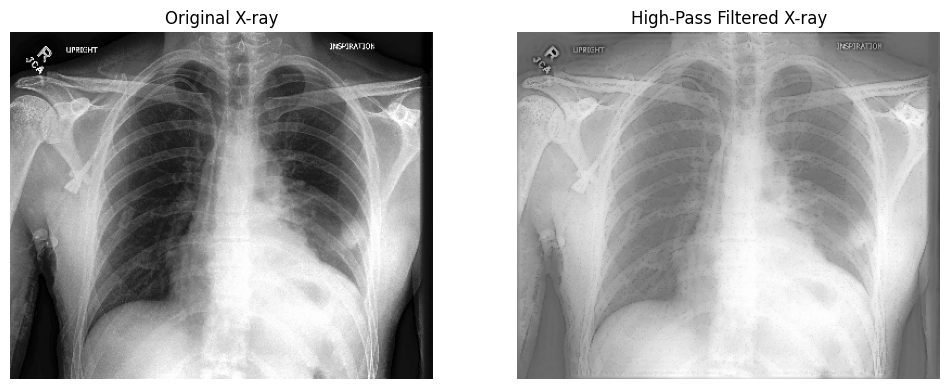

In [7]:
# Create High-Pass Filter (removes low frequencies)
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2

# Create a mask with a small black center (blocking low frequencies)
mask = np.ones((rows, cols), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 0

# Apply mask to FFT
filtered_f_shift = f_shift * mask

# Inverse FFT to get the image back
f_ishift = np.fft.ifftshift(filtered_f_shift)
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)

image_clean = image - img_filtered

# Display Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_clean, cmap="gray")
plt.title("High-Pass Filtered X-ray")
plt.axis("off")

plt.show()


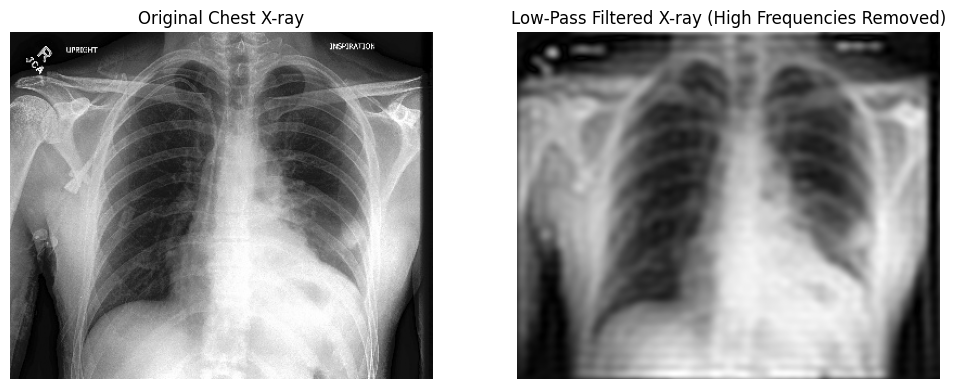

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

sample_image = r'..//..//datasets' + '/' + str(training_data['Path'][10])
image = plt.imread(sample_image)
# Compute the 2D Fourier Transform
f_transform = np.fft.fft2(image)
f_shift = np.fft.fftshift(f_transform)  # Shift low frequencies to center

# Create a Low-Pass Filter (Circular Mask)
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2  # Find center of image
radius = 30  # Adjust this value for more/less blurring

# Create a mask with a white circle at the center
Y, X = np.ogrid[:rows, :cols]
mask = (X - ccol)**2 + (Y - crow)**2 <= radius**2  # Circular mask

# Apply the mask to keep only low frequencies
filtered_f_shift = f_shift * mask

# Inverse FFT to get back the filtered image
f_ishift = np.fft.ifftshift(filtered_f_shift)  # Move back low frequencies
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)  # Convert complex values to real numbers

# Display the Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Chest X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_filtered, cmap="gray")
plt.title("Low-Pass Filtered X-ray (High Frequencies Removed)")
plt.axis("off")

plt.show()


In [ ]:
img_ = read_image(sample_image)

In [ ]:
img_.dtype

In [ ]:
img_

In [ ]:
img_f = img_.to(torch.float32)
img_f

In [ ]:
demographic_data = pd.read_csv('..\\..\datasets\CheXpert-v1.0-small\demographics_CXP.csv')
demographic_data.head()

In [ ]:
demographic_data.race.value_counts()

In [ ]:
path = training_data['Path']

In [ ]:
patientid = []
for i in path:
     id = i.split(sep='/')[2]
     id = id.replace("patient", "")
     patientid.append(float(id))

In [ ]:
patientid

In [ ]:
patient = pd.DataFrame(patientid,columns=['patient_id'])

In [ ]:
patient['patient_id'].nunique()

In [ ]:
demographic_data.nunique()

In [ ]:
training_data['subject_id'] = patient['patient_id']

In [ ]:
training_data.subject_id.nunique()

In [ ]:
training_data_merge = training_data.merge(demographic_data, on='subject_id')

In [ ]:
training_data_merge.subject_id.nunique()

In [ ]:
training_data_merge

In [ ]:
def select_most_positive_sample(group):
    """
    Selects the row with the highest number of disease-positive labels from a group of records belonging to the same patient.
    If all records have zero disease labels, it selects one at random.
    """
    disease_columns = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ]
    
    # Count the number of positive disease labels for each sample
    group['positive_count'] = group[disease_columns].sum(axis=1)
    
    # Filter to only include rows where at least one disease is positive
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:
        # Select the sample with the highest number of positive labels
        selected_sample = positive_cases.loc[positive_cases['positive_count'].idxmax()]
    else:
        # If no disease-positive samples exist, pick one randomly
        selected_sample = group.sample(n=1).iloc[0]
    
    return selected_sample

def sampling_datasets(training_dataset):
    """
    Applies the sampling strategy: selecting one recording per patient (`subject_id`),
    preferring samples with at least one disease-positive label.
    """
    # Group by patient ID and apply the selection function
    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    
    # Drop the temporary 'positive_count' column
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')
    
    return training_dataset


In [ ]:
training_data_merge = sampling_datasets(training_data_merge)

In [ ]:
training_data_merge['Frontal/Lateral'].value_counts()

In [ ]:
training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].replace(-1, 1)

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data_merge = training_data_merge[training_data_merge['Frontal/Lateral'] == 'Frontal']

In [ ]:
training_data_merge.fillna(0, inplace=True)

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data_merge[['No Finding']].value_counts()

In [ ]:
training_data_merge[['Edema']].value_counts()

In [ ]:
training_data_merge.subject_id.nunique()

In [ ]:
len(training_data_merge)

In [ ]:
labels = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']].values

In [ ]:
labels

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx] / 255.0
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
data_images = []
for path in training_data_merge['Path']:
     full_path = '../../datasets' + '/' + str(path)
     img = read_image(full_path)
     data_images.append(img)

In [ ]:
data_images

In [ ]:
mean, std = 0,0
images = [transform(image) for image in data_images]
for img in images:
     img = img.view(-1)
     mean += img.mean().sum()
     std += img.std().sum()

mean /= len(data_images)
std /= len(data_images)

print(f"Mean is : {mean:.4f}, STD is : {std:.4f}")

In [ ]:
labels = training_data_merge['No Finding'].values
data_labels = torch.tensor(labels, dtype=torch.float32)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda i: i/255),
    transforms.Lambda(lambda i: i.to(torch.float32)),
])

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
for i, l in dataloader:
     print(i.shape)
     print(l.shape)
     break

In [ ]:
def store_diagnostic_images_labels(training_data_merge):
    data_images = []
    paths = tqdm(training_data_merge['Path'], desc="Loading images")
    for path in paths:
        full_path = '../../datasets' + '/' + str(path)
        img = read_image(full_path)
        data_images.append(img)
        paths.set_postfix({'Loaded': len(data_images)})

    data_labels = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']].values
    data_labels = torch.tensor(data_labels, dtype=torch.float32)
    data_labels = torch.argmax(data_labels, dim=1)

    return data_images, data_labels

In [ ]:
def prepare_dataloaders(data_images, labels,shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((256,256), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Lambda(lambda i: i/255),
        transforms.Lambda(lambda i: i.to(torch.float32)),
        transforms.Normalize(mean=[0.50,0.50,0.50], std=[0.28,0.28,0.28])
    ])

    dataset = MyDataset(data_images,labels,transform)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=shuffle)

    return data_loader


In [ ]:
training_dataset = pd.read_csv('../../datasets/train_clean_dataset.csv')
validation_dataset = pd.read_csv('../../datasets/validation_clean_dataset.csv')

In [ ]:
train_data_images,train_labels = store_diagnostic_images_labels(training_dataset)
val_data_images, val_lables = store_diagnostic_images_labels(validation_dataset)
train_loader = prepare_dataloaders(train_data_images,train_labels, shuffle=True)
val_loader = prepare_dataloaders(val_data_images, val_lables,shuffle=False)

In [ ]:
# Variables to store pixel values
mean = 0.0
std = 0.0
num_samples = 0

for images, _ in dataloader:
    # images shape: (batch_size, 1, 256 * 256)
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, -1)  # Flatten pixels
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_samples += batch_samples

# Final mean and std
mean /= num_samples
std /= num_samples

print(f"Mean: {mean.item():.4f}, Std: {std.item():.4f}")


In [ ]:
top_5_races = training_data_merge['race'].value_counts().index[:5]
training_data_merge['race'] = training_data_merge['race'].where(training_data_merge['race'].isin(top_5_races))

In [ ]:
training_data_merge.race.value_counts()

In [ ]:
training_data_merge = pd.get_dummies(training_data_merge, columns=['race'], dtype=float)

In [ ]:
training_data_merge.columns

In [ ]:
labels = training_data_merge[['race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White']].values
labels = torch.tensor(labels, dtype=torch.float32)


In [ ]:
labels = torch.argmax(labels, dim=1)
labels

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1))
])

In [ ]:
class DenseNet_Model(nn.Module):
     def __init__(self, weights, out_feature):
          super().__init__()
          self.weight = weights
          self.out_feature = out_feature
          self.encoder = torchvision.models.densenet121(weights=weights)
          self.layer1 = nn.Linear(1000, 120)
          self.clf = nn.Linear(120, out_feature)

     
     def encode(self, x):
          return self.encoder(x)

     def forward(self, x):
          z = self.encode(x)
          z = self.layer1(z)
          return self.clf(z)
     

In [ ]:
model = DenseNet_Model(weights=None, out_feature=13)

In [ ]:
model

In [ ]:
m = torchvision.models.densenet121(weights=None)

In [ ]:
m

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
train_size = int(0.7 * len(dataset)) 
val_size = int(0.10 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for label, img in train_loader:
     print(label.shape, img.shape)
     break

In [ ]:

import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:

def log_roc_auc(y_true, y_scores, log=True, log_name="roc_auc_curve"):

    y_scores = np.array(y_scores)
    classes = np.unique(y_true) 
    y_true_bin = label_binarize(y_true, classes=classes)
    
    total_roc = 0

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        total_roc += roc_auc
        ax.plot(fpr, tpr, lw=2, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    # Plot settings
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multi-Class ROC Curve")
    ax.legend(loc="lower right")

    # Log to wandb
    if log:
        wandb.log({log_name: wandb.Image(fig)})
    else:
        print(f"{log_name} : {total_roc/len(classes)}")

    # Close figure to free memory
    plt.close(fig)


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def model_training(model, train_loader, val_loader, num_epochs=10, device=None, is_binary=False):
    model = model.to(device)

    all_train_labels, all_train_preds = [], []
    all_val_labels, all_val_preds = [], []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    early_stopper = EarlyStopper(patience=3)
    criterion = nn.BCEWithLogitsLoss() if is_binary else nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, tr_labels in train_loop:
            inputs, tr_labels = inputs.to(device), tr_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).to(device)

            # Convert predictions & labels
            if is_binary:
                tr_labels = tr_labels.unsqueeze(dim=1)
                tr_preds = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                tr_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_train_labels.extend(tr_labels.cpu().numpy())
            all_train_preds.extend(tr_preds)


            loss = criterion(outputs, tr_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, vl_labels in val_loop:
                inputs, vl_labels = inputs.to(device), vl_labels.to(device)

                outputs = model(inputs).to(device)
                if is_binary:
                    vl_labels = vl_labels.unsqueeze(dim=1)
                    vl_preds = torch.sigmoid(outputs).detach().cpu().numpy()
                else:
                    vl_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                all_val_labels.extend(vl_labels.cpu().numpy())
                all_val_preds.extend(vl_preds)

                loss = criterion(outputs, vl_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if early_stopper.early_stop(val_loss):
            break

        # Log metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        log_roc_auc(all_train_labels, all_train_preds, log=True, log_name='Training ROC-AUC')
        log_roc_auc(all_val_labels, all_val_preds, log=True, log_name='Validation ROC-AUC')

    # Final ROC-AUC Logging
    log_roc_auc(all_train_labels, all_train_preds, log=False, log_name='Training ROC-AUC')
    log_roc_auc(all_val_labels, all_val_preds, log=False, log_name='Validation ROC-AUC')



In [ ]:
weights = torch.load('no_finding_model_weights.pth', map_location='cpu')

In [ ]:
race_model = DenseNet_Model(weights=weights,out_feature=5)

In [ ]:
for param in race_model.encoder.parameters():
    param.requires_grad = False


In [ ]:
model_training(race_model,train_loader,val_loader,num_epochs=10,is_binary=False)

In [ ]:
torch.save(race_model.state_dict(), 'race_finding_model_weights.pth')

In [ ]:
test_model = DenseNet_Model(weights=None, out_feature=5)

In [ ]:
weights = torch.load('race_finding_model_weights.pth',map_location='cpu')

In [ ]:
test_model.load_state_dict(weights,strict=True)

In [ ]:
def testing_model(test_loader, model, device, is_binary=False):
    model.to(device)
    model.eval()

    all_test_labels, all_test_preds = [], []

    loader = tqdm(test_loader)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if is_binary:
                labels = labels.view(-1, 1)
                predicted = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                predicted = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted)

    log_roc_auc(all_test_labels, all_test_preds, log=True, log_name='Testing ROC-AUC')
    log_roc_auc(all_test_labels, all_test_preds, log=False, log_name='Testing ROC-AUC')



In [ ]:
testing_model(test_loader,test_model,'cpu')